<a href="https://colab.research.google.com/github/WenyiYao/cryptocurrency/blob/main/lstm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import os
import pandas as pd
import numpy as np

In [2]:
df = pd.read_json('USDC-ETH.json')
df.head()

,id,high,low,tvlUSD,txCount,volumeUSD,date,open,tick,close
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19251,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,2022-09-16,1472.111248,203641,1433.463152
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19252,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,2022-09-17,1433.463152,203394,1469.404359
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19253,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,2022-09-18,1469.404359,204359,1334.321067
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19254,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,2022-09-19,1334.321067,204053,1375.641442
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640-19255,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,2022-09-20,1375.641442,204440,1322.192169


In [3]:
df = df.drop(columns=["id"])
df = df.set_index(['date'])
df.head()

,high,low,tvlUSD,txCount,volumeUSD,open,tick,close
date,,,,,,,,
2022-09-16,1483.170696,1396.900687,2.517911e+08,11053,4.784684e+08,1472.111248,203641,1433.463152
2022-09-17,1476.144985,1402.098845,2.666791e+08,9014,2.088181e+08,1433.463152,203394,1469.404359
2022-09-18,1469.421851,1324.864844,2.485486e+08,10707,2.443570e+08,1469.404359,204359,1334.321067
2022-09-19,1392.051034,1274.907911,2.609486e+08,13410,3.697855e+08,1334.321067,204053,1375.641442
2022-09-20,1383.911802,1313.997663,2.540213e+08,11117,3.349061e+08,1375.641442,204440,1322.192169


In [4]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=df.index,
                                     open=df['open'],
                                     high=df['high'],
                                     low=df['low'],
                                     close=df['close'])])
fig.show()

In [5]:
dataset = df.values
dataset

array([[1.48317070e+03, 1.39690069e+03, 2.51791059e+08, ...,
        1.47211125e+03, 2.03641000e+05, 1.43346315e+03],
       [1.47614498e+03, 1.40209885e+03, 2.66679134e+08, ...,
        1.43346315e+03, 2.03394000e+05, 1.46940436e+03],
       [1.46942185e+03, 1.32486484e+03, 2.48548636e+08, ...,
        1.46940436e+03, 2.04359000e+05, 1.33432107e+03],
       ...,
       [1.91744262e+03, 1.87164646e+03, 4.21586684e+08, ...,
        1.89410228e+03, 2.00821000e+05, 1.90038819e+03],
       [1.90651873e+03, 1.85254812e+03, 4.21238435e+08, ...,
        1.90038819e+03, 2.00893000e+05, 1.88681227e+03],
       [1.90372155e+03, 1.87535372e+03, 4.25635507e+08, ...,
        1.88681227e+03, 2.00841000e+05, 0.00000000e+00]])

In [6]:
dataset.shape

(419, 8)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+1:(i+look_back+1),[0,1,7]]) #predict high, low, and close
    return numpy.array(dataX), numpy.array(dataY)

In [9]:
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [10]:
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [11]:
print(trainX.shape)
print(trainY.shape)

(288, 4, 8)
(288, 4, 3)


In [12]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))

In [13]:
batch_size = 8
model0 = Sequential()
model0.add(LSTM(6, batch_input_shape=(batch_size, look_back, 8), stateful=True, return_sequences=True))
model0.add(TimeDistributed(Dense(3)))
model0.compile(loss='mean_squared_error', optimizer='adam')

Epoch 1/10
33/33 - 7s - loss: 0.2657 - val_loss: 0.3279 - 7s/epoch - 203ms/step
Epoch 2/10
33/33 - 0s - loss: 0.1090 - val_loss: 0.1631 - 255ms/epoch - 8ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0576 - val_loss: 0.0890 - 409ms/epoch - 12ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0425 - val_loss: 0.0576 - 274ms/epoch - 8ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0374 - val_loss: 0.0424 - 262ms/epoch - 8ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0346 - val_loss: 0.0339 - 321ms/epoch - 10ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0323 - val_loss: 0.0285 - 347ms/epoch - 11ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0301 - val_loss: 0.0246 - 358ms/epoch - 11ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0278 - val_loss: 0.0214 - 297ms/epoch - 9ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0257 - val_loss: 0.0187 - 233ms/epoch - 7ms/step


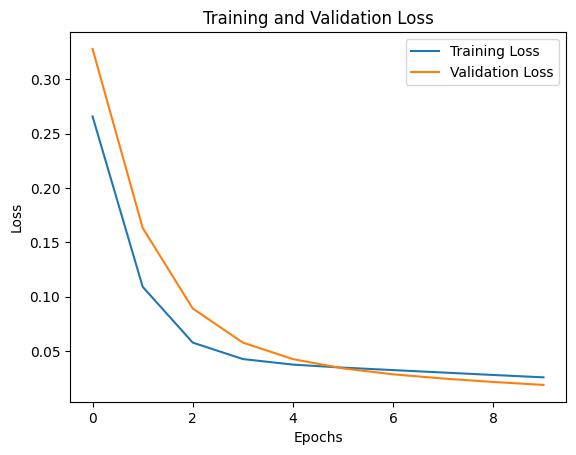

Epoch 1/10
33/33 - 0s - loss: 0.0216 - val_loss: 0.0155 - 384ms/epoch - 12ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0218 - val_loss: 0.0139 - 284ms/epoch - 9ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0199 - val_loss: 0.0121 - 278ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0180 - val_loss: 0.0105 - 246ms/epoch - 7ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0164 - val_loss: 0.0091 - 285ms/epoch - 9ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0150 - val_loss: 0.0080 - 266ms/epoch - 8ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0137 - val_loss: 0.0072 - 256ms/epoch - 8ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0125 - val_loss: 0.0065 - 242ms/epoch - 7ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0114 - val_loss: 0.0059 - 276ms/epoch - 8ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0105 - val_loss: 0.0055 - 289ms/epoch - 9ms/step


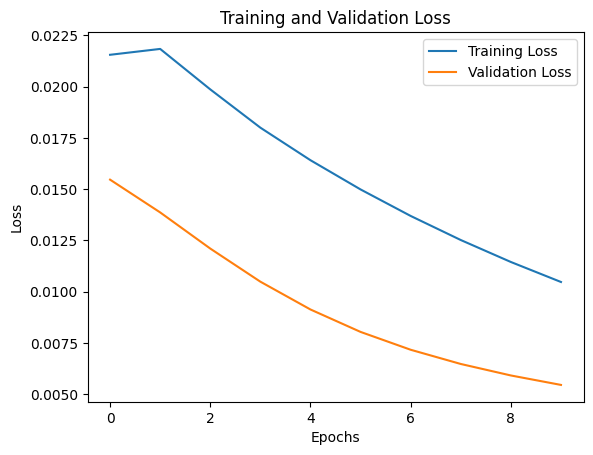

Epoch 1/10
33/33 - 1s - loss: 0.0077 - val_loss: 0.0050 - 561ms/epoch - 17ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0090 - val_loss: 0.0047 - 460ms/epoch - 14ms/step
Epoch 3/10
33/33 - 1s - loss: 0.0083 - val_loss: 0.0045 - 512ms/epoch - 16ms/step
Epoch 4/10
33/33 - 1s - loss: 0.0078 - val_loss: 0.0044 - 572ms/epoch - 17ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0074 - val_loss: 0.0043 - 327ms/epoch - 10ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0071 - val_loss: 0.0042 - 400ms/epoch - 12ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0068 - val_loss: 0.0042 - 430ms/epoch - 13ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0066 - val_loss: 0.0041 - 383ms/epoch - 12ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0064 - val_loss: 0.0041 - 411ms/epoch - 12ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0062 - val_loss: 0.0041 - 488ms/epoch - 15ms/step


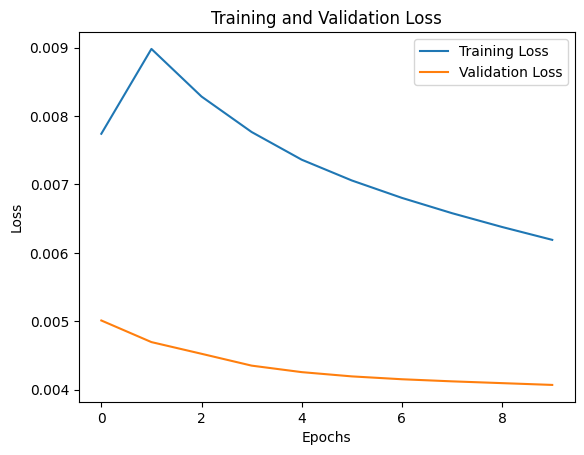

Epoch 1/10
33/33 - 0s - loss: 0.0047 - val_loss: 0.0041 - 260ms/epoch - 8ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0060 - val_loss: 0.0040 - 388ms/epoch - 12ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0057 - val_loss: 0.0040 - 400ms/epoch - 12ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0056 - val_loss: 0.0040 - 319ms/epoch - 10ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0054 - val_loss: 0.0039 - 270ms/epoch - 8ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0053 - val_loss: 0.0039 - 278ms/epoch - 8ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0051 - val_loss: 0.0039 - 264ms/epoch - 8ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0050 - val_loss: 0.0038 - 208ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0049 - val_loss: 0.0038 - 308ms/epoch - 9ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0048 - val_loss: 0.0037 - 291ms/epoch - 9ms/step


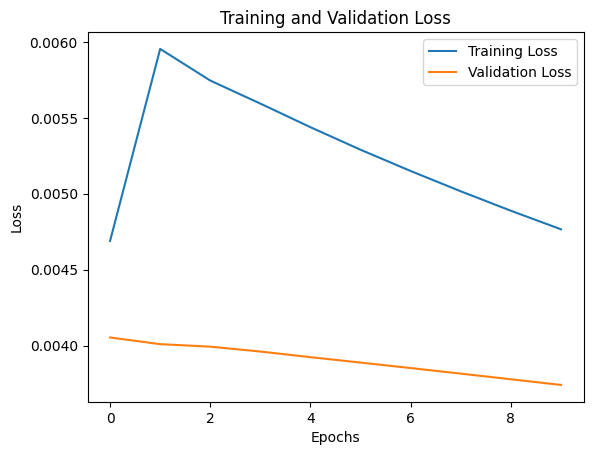

Epoch 1/10
33/33 - 0s - loss: 0.0040 - val_loss: 0.0037 - 436ms/epoch - 13ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0046 - val_loss: 0.0036 - 383ms/epoch - 12ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0045 - val_loss: 0.0036 - 279ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0044 - val_loss: 0.0036 - 268ms/epoch - 8ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0043 - val_loss: 0.0036 - 281ms/epoch - 9ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0042 - val_loss: 0.0035 - 215ms/epoch - 7ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0041 - val_loss: 0.0035 - 127ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0040 - val_loss: 0.0034 - 142ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0039 - val_loss: 0.0034 - 152ms/epoch - 5ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0038 - val_loss: 0.0034 - 144ms/epoch - 4ms/step


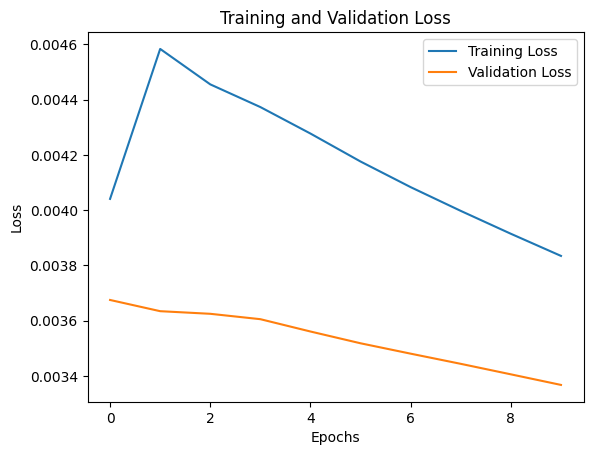

Epoch 1/10
33/33 - 0s - loss: 0.0036 - val_loss: 0.0033 - 173ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0037 - val_loss: 0.0032 - 131ms/epoch - 4ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0036 - val_loss: 0.0032 - 151ms/epoch - 5ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0036 - val_loss: 0.0032 - 141ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0035 - val_loss: 0.0032 - 134ms/epoch - 4ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0034 - val_loss: 0.0031 - 142ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0034 - val_loss: 0.0031 - 142ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0033 - val_loss: 0.0031 - 131ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0033 - val_loss: 0.0030 - 141ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0032 - val_loss: 0.0030 - 131ms/epoch - 4ms/step


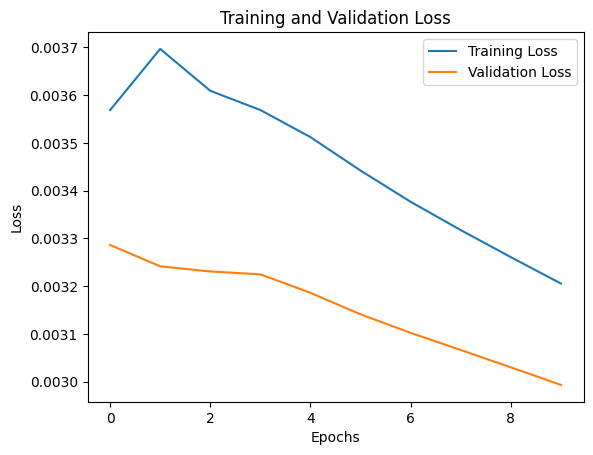

Epoch 1/10
33/33 - 0s - loss: 0.0032 - val_loss: 0.0029 - 164ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0031 - val_loss: 0.0029 - 126ms/epoch - 4ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0030 - val_loss: 0.0028 - 137ms/epoch - 4ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0030 - val_loss: 0.0028 - 144ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0030 - val_loss: 0.0028 - 154ms/epoch - 5ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0029 - val_loss: 0.0028 - 129ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0029 - val_loss: 0.0027 - 121ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0028 - val_loss: 0.0027 - 141ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0028 - val_loss: 0.0027 - 152ms/epoch - 5ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0028 - val_loss: 0.0026 - 137ms/epoch - 4ms/step


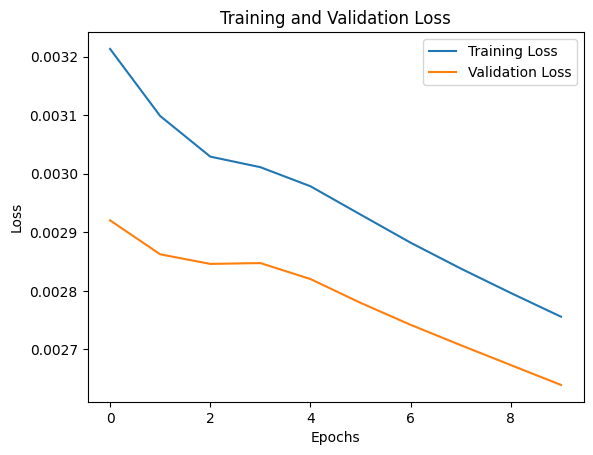

Epoch 1/10
33/33 - 0s - loss: 0.0029 - val_loss: 0.0026 - 242ms/epoch - 7ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0027 - val_loss: 0.0025 - 213ms/epoch - 6ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0026 - val_loss: 0.0025 - 213ms/epoch - 6ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0026 - val_loss: 0.0025 - 187ms/epoch - 6ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0026 - val_loss: 0.0025 - 202ms/epoch - 6ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0026 - val_loss: 0.0024 - 178ms/epoch - 5ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0025 - val_loss: 0.0024 - 212ms/epoch - 6ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0025 - val_loss: 0.0024 - 197ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0025 - val_loss: 0.0024 - 210ms/epoch - 6ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0024 - val_loss: 0.0023 - 202ms/epoch - 6ms/step


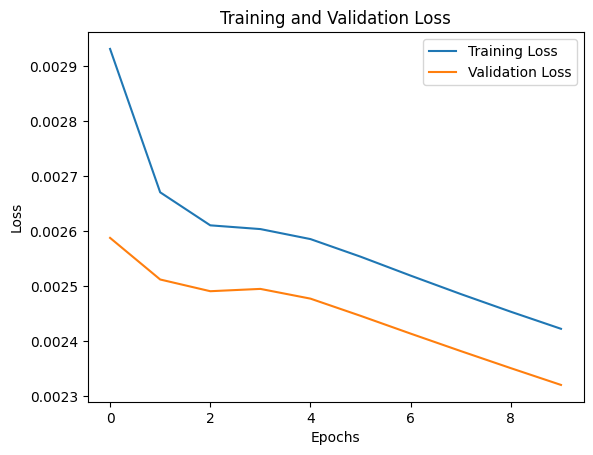

Epoch 1/10
33/33 - 0s - loss: 0.0027 - val_loss: 0.0023 - 243ms/epoch - 7ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0024 - val_loss: 0.0022 - 205ms/epoch - 6ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0023 - val_loss: 0.0022 - 221ms/epoch - 7ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0023 - val_loss: 0.0022 - 198ms/epoch - 6ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0023 - val_loss: 0.0022 - 197ms/epoch - 6ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0023 - val_loss: 0.0021 - 213ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0022 - val_loss: 0.0021 - 165ms/epoch - 5ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0022 - val_loss: 0.0021 - 140ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0022 - val_loss: 0.0021 - 130ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0022 - val_loss: 0.0020 - 138ms/epoch - 4ms/step


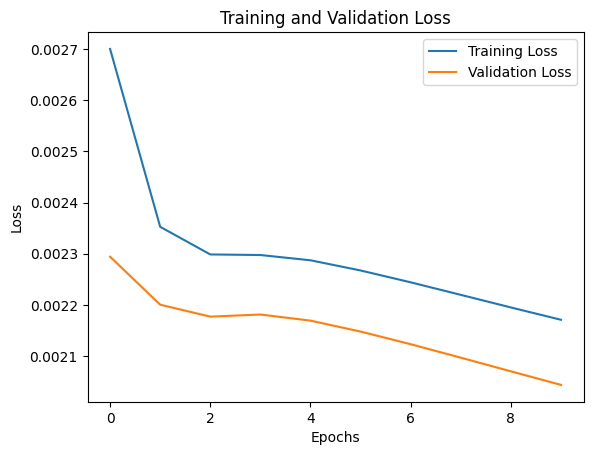

Epoch 1/10
33/33 - 0s - loss: 0.0025 - val_loss: 0.0020 - 215ms/epoch - 7ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0021 - val_loss: 0.0019 - 166ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0021 - val_loss: 0.0019 - 182ms/epoch - 6ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0021 - val_loss: 0.0019 - 133ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0021 - val_loss: 0.0019 - 153ms/epoch - 5ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0019 - 141ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0019 - 153ms/epoch - 5ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0019 - 160ms/epoch - 5ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0018 - 145ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0018 - 135ms/epoch - 4ms/step


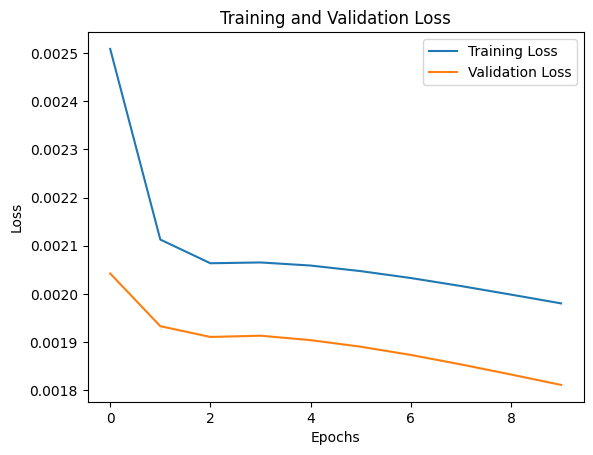

Epoch 1/10
33/33 - 0s - loss: 0.0023 - val_loss: 0.0018 - 201ms/epoch - 6ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 158ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 164ms/epoch - 5ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 136ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 142ms/epoch - 4ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 146ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 142ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0017 - 147ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0016 - 158ms/epoch - 5ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0016 - 150ms/epoch - 5ms/step


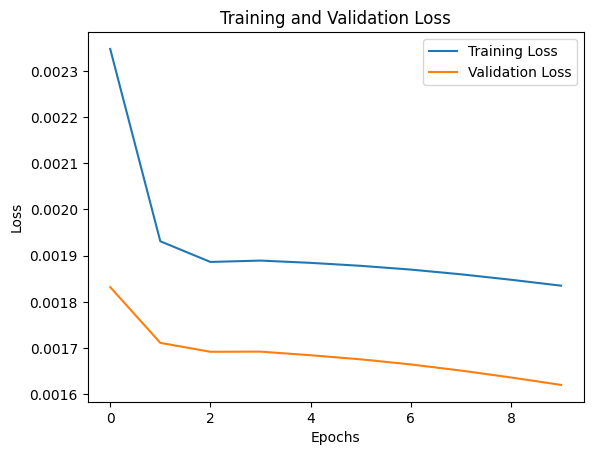

Epoch 1/10
33/33 - 0s - loss: 0.0022 - val_loss: 0.0017 - 178ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0015 - 133ms/epoch - 4ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0015 - 173ms/epoch - 5ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0015 - 149ms/epoch - 5ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0015 - 141ms/epoch - 4ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0015 - 132ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0015 - 136ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0015 - 144ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0015 - 141ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0015 - 139ms/epoch - 4ms/step


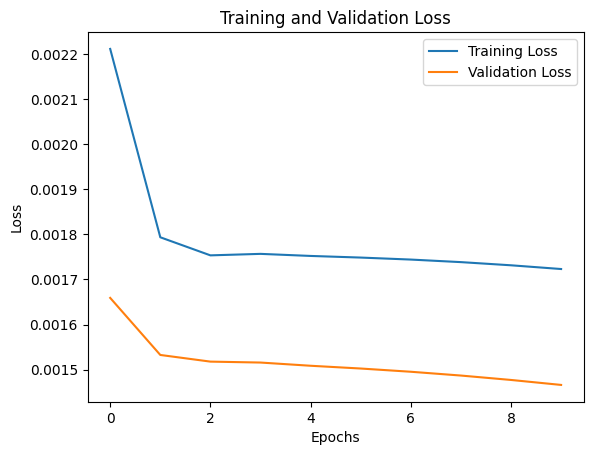

Epoch 1/10
33/33 - 0s - loss: 0.0021 - val_loss: 0.0015 - 199ms/epoch - 6ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0014 - 143ms/epoch - 4ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0014 - 169ms/epoch - 5ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0014 - 160ms/epoch - 5ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0014 - 197ms/epoch - 6ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0014 - 183ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0014 - 167ms/epoch - 5ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0014 - 187ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 221ms/epoch - 7ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 192ms/epoch - 6ms/step


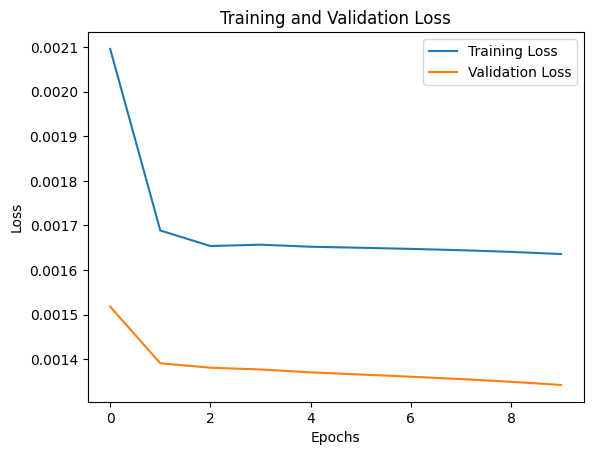

Epoch 1/10
33/33 - 0s - loss: 0.0020 - val_loss: 0.0014 - 250ms/epoch - 8ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 206ms/epoch - 6ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 191ms/epoch - 6ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 198ms/epoch - 6ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 200ms/epoch - 6ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 201ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 230ms/epoch - 7ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0013 - 188ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0012 - 186ms/epoch - 6ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0012 - 173ms/epoch - 5ms/step


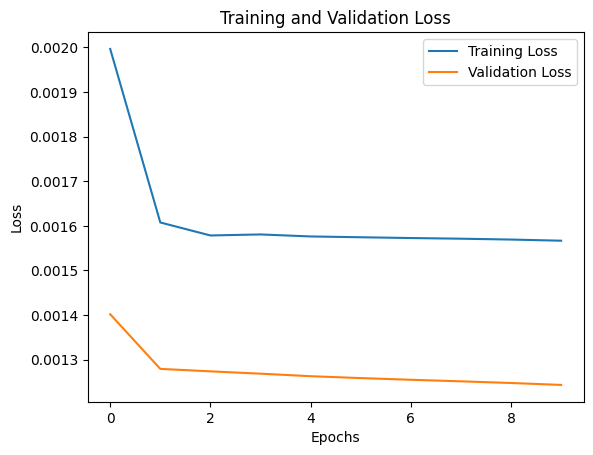

Epoch 1/10
33/33 - 0s - loss: 0.0019 - val_loss: 0.0013 - 172ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 154ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 130ms/epoch - 4ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 159ms/epoch - 5ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 137ms/epoch - 4ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 205ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 239ms/epoch - 7ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 221ms/epoch - 7ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 242ms/epoch - 7ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0012 - 253ms/epoch - 8ms/step


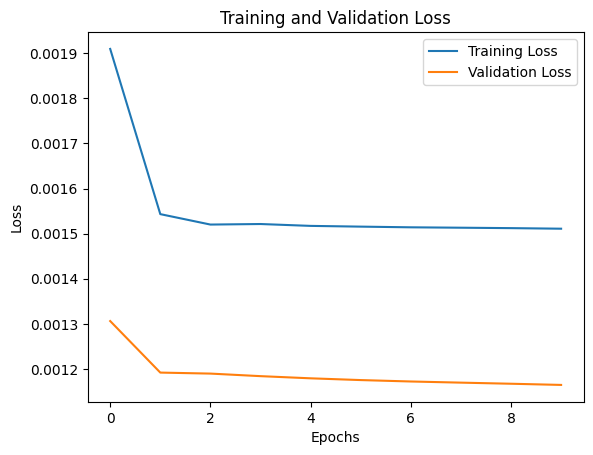

Epoch 1/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0012 - 286ms/epoch - 9ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 233ms/epoch - 7ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 260ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 286ms/epoch - 9ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 313ms/epoch - 9ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 322ms/epoch - 10ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 288ms/epoch - 9ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 290ms/epoch - 9ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 312ms/epoch - 9ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0015 - val_loss: 0.0011 - 253ms/epoch - 8ms/step


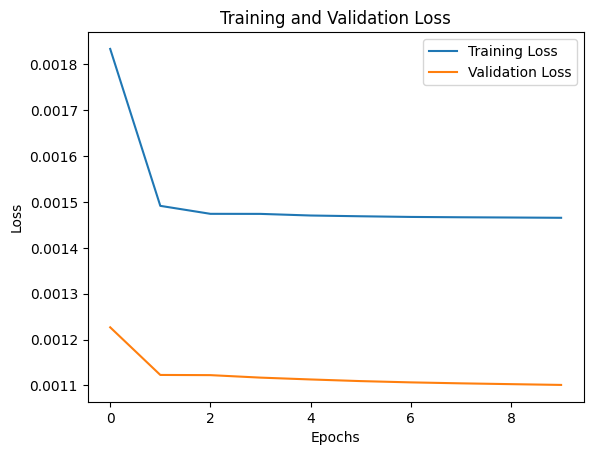

Epoch 1/10
33/33 - 0s - loss: 0.0018 - val_loss: 0.0012 - 292ms/epoch - 9ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 243ms/epoch - 7ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 278ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 301ms/epoch - 9ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 257ms/epoch - 8ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 281ms/epoch - 9ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 235ms/epoch - 7ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 228ms/epoch - 7ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0011 - 212ms/epoch - 6ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 274ms/epoch - 8ms/step


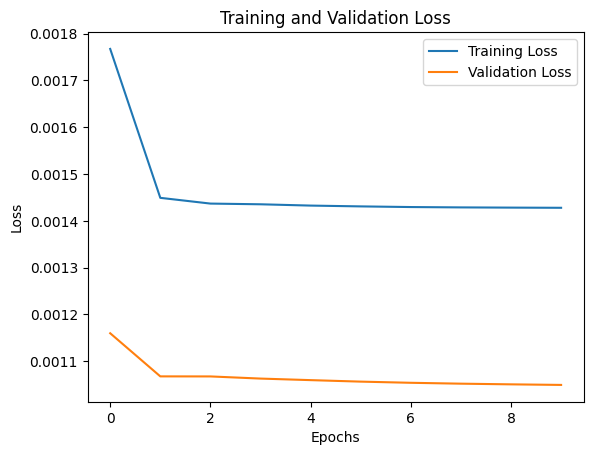

Epoch 1/10
33/33 - 1s - loss: 0.0017 - val_loss: 0.0011 - 533ms/epoch - 16ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 320ms/epoch - 10ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 387ms/epoch - 12ms/step
Epoch 4/10
33/33 - 1s - loss: 0.0014 - val_loss: 0.0010 - 506ms/epoch - 15ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 485ms/epoch - 15ms/step
Epoch 6/10
33/33 - 1s - loss: 0.0014 - val_loss: 0.0010 - 544ms/epoch - 16ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 360ms/epoch - 11ms/step
Epoch 8/10
33/33 - 1s - loss: 0.0014 - val_loss: 0.0010 - 604ms/epoch - 18ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 449ms/epoch - 14ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0014 - val_loss: 0.0010 - 374ms/epoch - 11ms/step


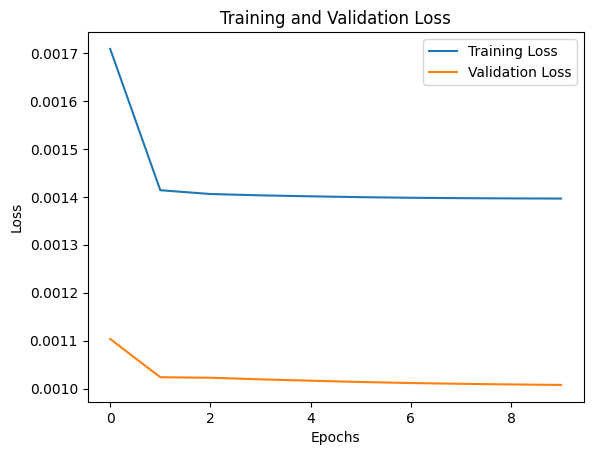

Epoch 1/10
33/33 - 0s - loss: 0.0017 - val_loss: 0.0011 - 483ms/epoch - 15ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.8799e-04 - 242ms/epoch - 7ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.8511e-04 - 270ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.8317e-04 - 477ms/epoch - 14ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.8061e-04 - 272ms/epoch - 8ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.7855e-04 - 246ms/epoch - 7ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.7673e-04 - 257ms/epoch - 8ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.7532e-04 - 242ms/epoch - 7ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.7421e-04 - 215ms/epoch - 7ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.7337e-04 - 291ms/epoch - 9ms/step


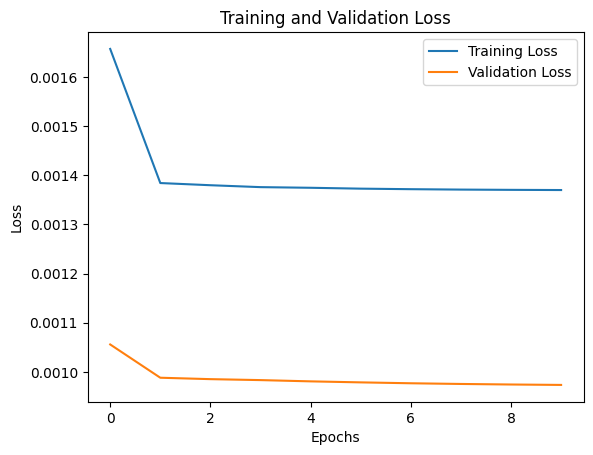

Epoch 1/10
33/33 - 0s - loss: 0.0016 - val_loss: 0.0010 - 345ms/epoch - 10ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.5927e-04 - 275ms/epoch - 8ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.5417e-04 - 253ms/epoch - 8ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.5360e-04 - 252ms/epoch - 8ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.5112e-04 - 272ms/epoch - 8ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0014 - val_loss: 9.4966e-04 - 188ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.4822e-04 - 132ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.4715e-04 - 147ms/epoch - 4ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.4627e-04 - 170ms/epoch - 5ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.4561e-04 - 143ms/epoch - 4ms/step


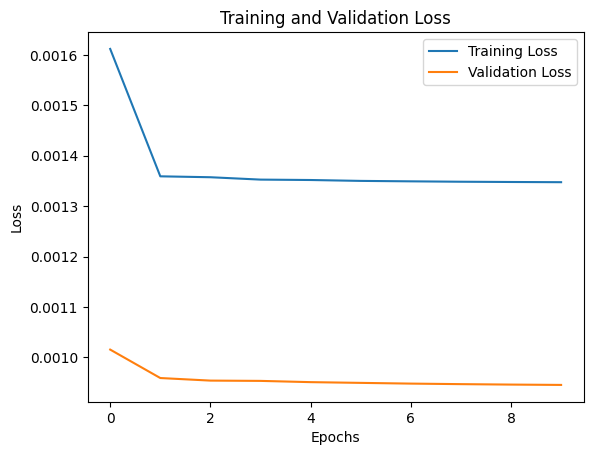

Epoch 1/10
33/33 - 0s - loss: 0.0016 - val_loss: 9.8241e-04 - 179ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.3617e-04 - 160ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2889e-04 - 159ms/epoch - 5ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2948e-04 - 140ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2695e-04 - 149ms/epoch - 5ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2601e-04 - 148ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2490e-04 - 150ms/epoch - 5ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2418e-04 - 162ms/epoch - 5ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2358e-04 - 141ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.2313e-04 - 149ms/epoch - 5ms/step


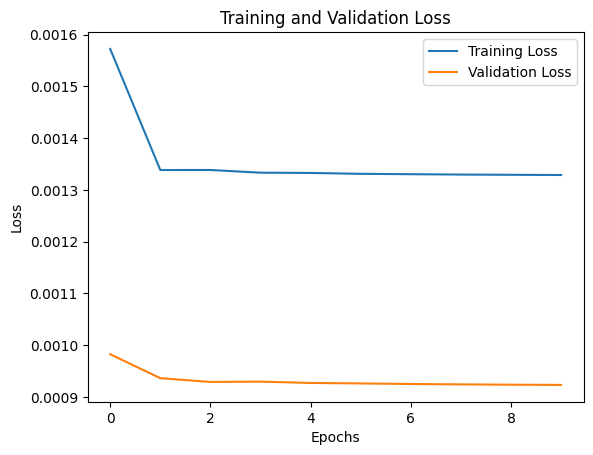

Epoch 1/10
33/33 - 0s - loss: 0.0015 - val_loss: 9.5512e-04 - 180ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.1762e-04 - 161ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0854e-04 - 144ms/epoch - 4ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0993e-04 - 229ms/epoch - 7ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0734e-04 - 215ms/epoch - 7ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0675e-04 - 195ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0591e-04 - 193ms/epoch - 6ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0548e-04 - 219ms/epoch - 7ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0513e-04 - 194ms/epoch - 6ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0490e-04 - 216ms/epoch - 7ms/step


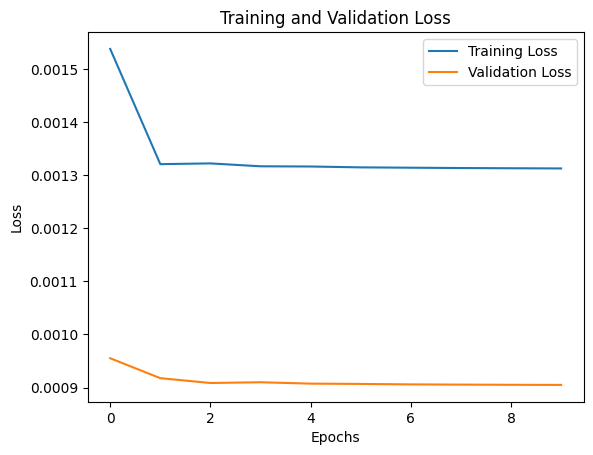

Epoch 1/10
33/33 - 0s - loss: 0.0015 - val_loss: 9.3280e-04 - 263ms/epoch - 8ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0013 - val_loss: 9.0258e-04 - 200ms/epoch - 6ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9222e-04 - 214ms/epoch - 6ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9404e-04 - 206ms/epoch - 6ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9145e-04 - 209ms/epoch - 6ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9106e-04 - 193ms/epoch - 6ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9040e-04 - 216ms/epoch - 7ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9017e-04 - 196ms/epoch - 6ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9001e-04 - 141ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.8995e-04 - 155ms/epoch - 5ms/step


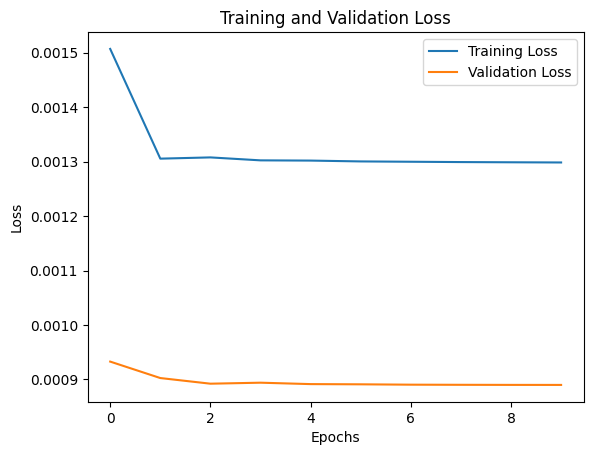

Epoch 1/10
33/33 - 0s - loss: 0.0015 - val_loss: 9.1441e-04 - 180ms/epoch - 5ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.9013e-04 - 138ms/epoch - 4ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7899e-04 - 130ms/epoch - 4ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.8093e-04 - 133ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7842e-04 - 143ms/epoch - 4ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7809e-04 - 139ms/epoch - 4ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7755e-04 - 131ms/epoch - 4ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7742e-04 - 151ms/epoch - 5ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7739e-04 - 142ms/epoch - 4ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7745e-04 - 140ms/epoch - 4ms/step


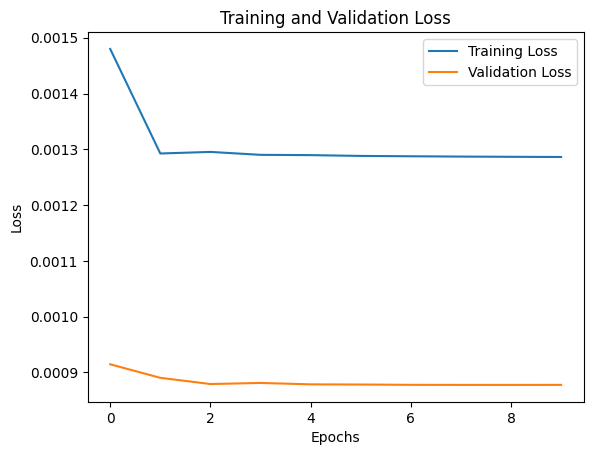

Epoch 1/10
33/33 - 0s - loss: 0.0015 - val_loss: 8.9903e-04 - 218ms/epoch - 7ms/step
Epoch 2/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.7947e-04 - 149ms/epoch - 5ms/step
Epoch 3/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6800e-04 - 141ms/epoch - 4ms/step
Epoch 4/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6983e-04 - 144ms/epoch - 4ms/step
Epoch 5/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6746e-04 - 155ms/epoch - 5ms/step
Epoch 6/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6713e-04 - 154ms/epoch - 5ms/step
Epoch 7/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6667e-04 - 156ms/epoch - 5ms/step
Epoch 8/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6660e-04 - 154ms/epoch - 5ms/step
Epoch 9/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6664e-04 - 152ms/epoch - 5ms/step
Epoch 10/10
33/33 - 0s - loss: 0.0013 - val_loss: 8.6677e-04 - 144ms/epoch - 4ms/step


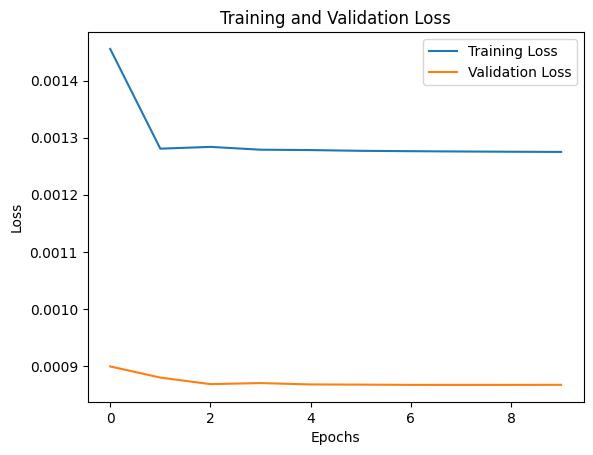

In [14]:
# Create a separate validation set
validation_size = int(len(trainX) * 0.1)
validation_size = (validation_size // batch_size) * batch_size
validationX, validationY = trainX[-validation_size:], trainY[-validation_size:]
trainX = trainX[:-validation_size]
trainY = trainY[:-validation_size]

for i in range(25):
    history = model0.fit(trainX, trainY, epochs=10, batch_size=batch_size, validation_data=(validationX, validationY), verbose=2, shuffle=False)
    model0.reset_states()

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [15]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (8, 4, 6)                 360       
                                                                 
 time_distributed (TimeDist  (8, 4, 3)                 21        
 ributed)                                                        
                                                                 
Total params: 381 (1.49 KB)
Trainable params: 381 (1.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_metrics(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

# high value metrics
testPredict = model0.predict(testX, batch_size=batch_size)
calculate_metrics(testY[:, -1, 0], testPredict[:testY.shape[0], -1, 0])

16/16 [==============================] - 1s 3ms/step


{'MSE': 0.0009738877276315745,
 'RMSE': 0.03120717429745241,
 'MAE': 0.02652872581181871,
 'R2': 0.9341144813823317}

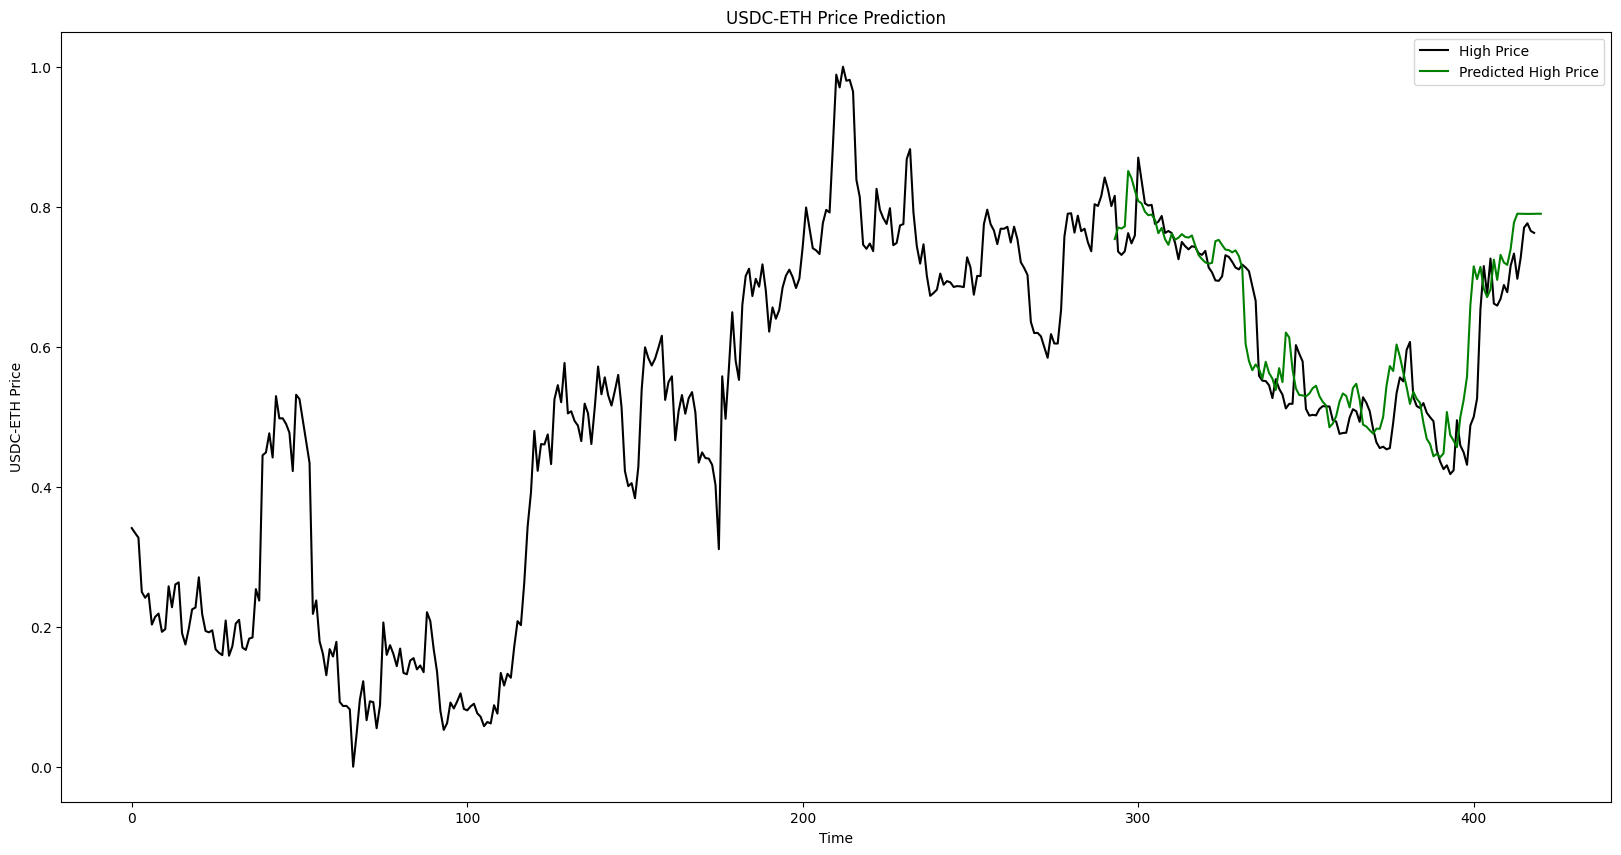

In [17]:
date_index = train_size
plt.figure(figsize=(20, 10))
plt.plot(dataset[:,0], color = 'black', label = 'High Price')
plt.plot(range(date_index, date_index + len(testPredict)), testPredict[:, -1, 0], color = 'green', label = 'Predicted High Price')
plt.title('USDC-ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('USDC-ETH Price')
plt.legend()
plt.show()

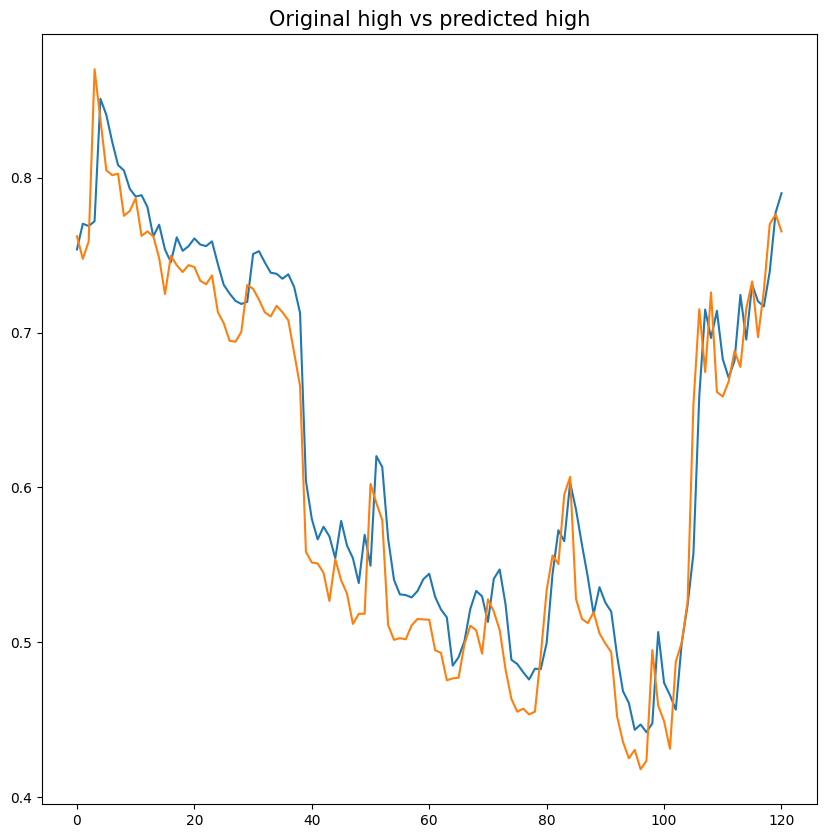

In [18]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 0])
plt.plot(testY[:, -1, 0])
plt.title('Original high vs predicted high', fontsize=15)
plt.show()

In [19]:
trainPredict = model0.predict(trainX, batch_size=batch_size)
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 0], trainPredict[:, -1, 0]))
print('Train Score of high value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 1], trainPredict[:, -1, 1]))
print('Train Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(trainX[:, -1, 2], trainPredict[:, -1, 2]))
print('Train Score of close value: %.10f RMSE' % (trainScore))
model0.reset_states()

33/33 [==============================] - 0s 3ms/step
Train Score of high value: 0.0210521871 RMSE
Train Score of low value: 0.0318930315 RMSE
Train Score of close value: 0.3365906921 RMSE


In [20]:
testPredict = model0.predict(testX, batch_size=batch_size)
testScore = math.sqrt(mean_squared_error(testY[:, -1, 0], testPredict[0:testY.shape[0], -1, 0]))
print('Test Score of high value: %.10f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 1], testPredict[0:testY.shape[0], -1, 1]))
print('Test Score of low value: %.10f RMSE' % (trainScore))
trainScore = math.sqrt(mean_squared_error(testY[:, -1, 2], testPredict[0:testY.shape[0], -1, 2]))
print('Test Score of close value: %.10f RMSE' % (trainScore))

16/16 [==============================] - 0s 2ms/step
Test Score of high value: 0.0312071743 RMSE
Test Score of low value: 0.0348322769 RMSE
Test Score of close value: 0.0188966648 RMSE


In [21]:
print(trainPredict.shape)
print(trainY.shape)

(264, 4, 3)
(264, 4, 3)


In [22]:
print(testPredict.shape)
print(testY.shape)

(128, 4, 3)
(121, 4, 3)


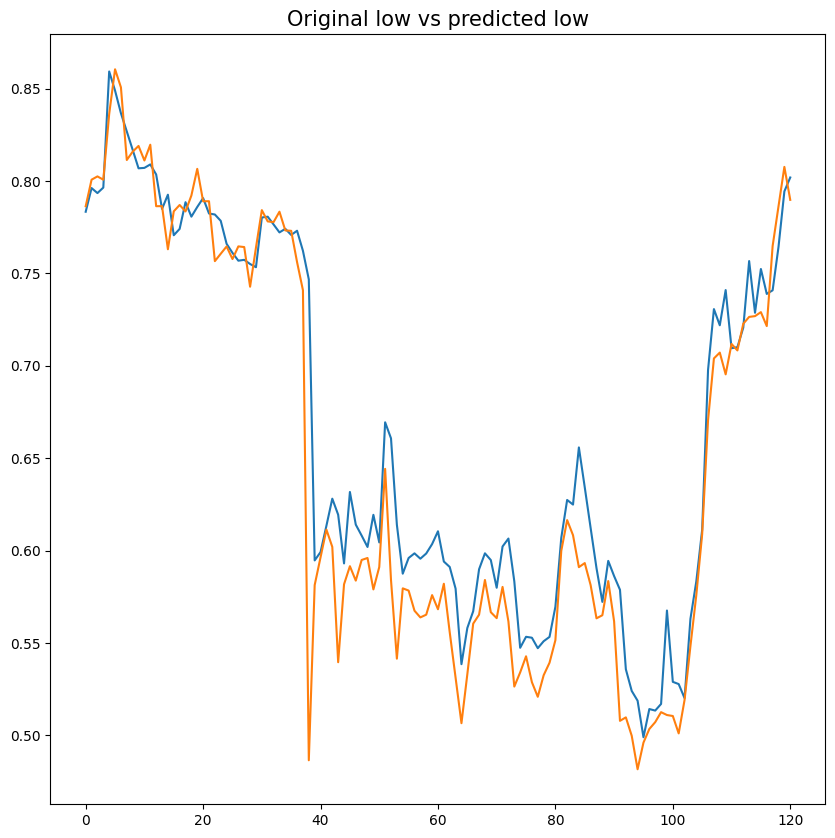

In [23]:
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 1])
plt.plot(testY[:, -1, 1])
plt.title('Original low vs predicted low', fontsize=15)
plt.show()

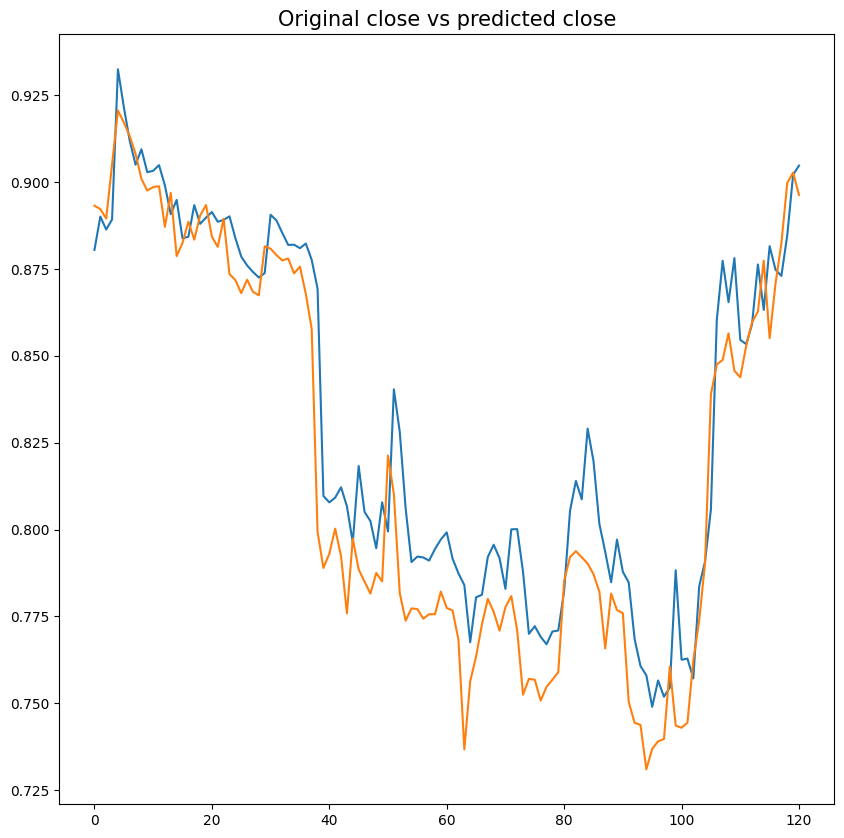

In [24]:
#testY=testY.reshape(-1,1)
plt.figure(figsize=(10, 10))
plt.plot(testPredict[0:testY.shape[0], -1, 2])
plt.plot(testY[:, -1, 2])
plt.title('Original close vs predicted close', fontsize=15)
plt.show()